In [2]:
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
hour = []
aqi = []

with open('./AQI-Hourly-cleaned.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    aqi.append(float(row[5]))
    hour.append(row[0])

series = np.array(aqi)
time = np.array(hour)
plt.figure(figsize=(10, 6))
plot_series(time, series)

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

In [4]:
split_time = 24399 #2016-2017 for validation set
time_train = time[:split_time]
x_train = series[:split_time]
time_validate = time[split_time:]
x_validate = series[split_time:]

window_size = 60
batch_size = 24
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
    
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    return model.predict(ds)

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60
batch_size = 24
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(24399,)
Epoch 1/50
1015/1015 [==============================] - 28s 13ms/step - loss: 25.6451 - mae: 26.1362 - lr: 1.0000e-07
Epoch 2/50
1015/1015 [==============================] - 12s 12ms/step - loss: 18.5852 - mae: 19.0730 - lr: 1.1220e-07
Epoch 3/50
1015/1015 [==============================] - 13s 13ms/step - loss: 15.5130 - mae: 15.9991 - lr: 1.2589e-07
Epoch 4/50
1015/1015 [==============================] - 13s 13ms/step - loss: 13.7675 - mae: 14.2525 - lr: 1.4125e-07
Epoch 5/50
1015/1015 [==============================] - 13s 13ms/step - loss: 12.6585 - mae: 13.1422 - lr: 1.5849e-07
Epoch 6/50
1015/1015 [==============================] - 13s 13ms/step - loss: 12.0008 - mae: 12.4834 - lr: 1.7783e-07
Epoch 7/50
1015/1015 [==============================] - 13s 12ms/step - loss: 11.4386 - mae: 11.9204 - lr: 1.9953e-07
Epoch

(1e-07, 3e-05, 0.0, 60.0)

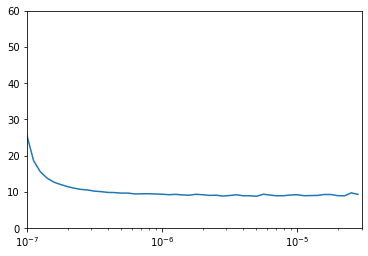

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 3e-5, 0, 60])

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=batch_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=7.1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
1016/1016 [==============================] - 13s 10ms/step - loss: 13.7301 - mae: 14.2141
Epoch 2/100
1016/1016 [==============================] - 10s 10ms/step - loss: 10.5720 - mae: 11.0534
Epoch 3/100
1016/1016 [==============================] - 10s 10ms/step - loss: 9.7581 - mae: 10.2381
Epoch 4/100
1016/1016 [==============================] - 11s 10ms/step - loss: 9.4002 - mae: 9.8797
Epoch 5/100
1016/1016 [==============================] - 10s 10ms/step - loss: 9.0528 - mae: 9.5318
Epoch 6/100
1016/1016 [==============================] - 10s 10ms/step - loss: 8.9204 - mae: 9.3993
Epoch 7/100
1016/1016 [==============================] - 10s 10ms/step - loss: 8.8223 - mae: 9.3010
Epoch 8/100
1016/1016 [==============================] - 10s 9ms/step - loss: 8.7662 - mae: 9.2447
Epoch 9/100
1016/1016 [==============================] - 10s 10ms/step - loss: 8.6518 - mae: 9.1301
Epoch 10/100
1016/1016 [==============================] - 10s 10ms/step - loss: 8.7852 - mae: 9.

In [18]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

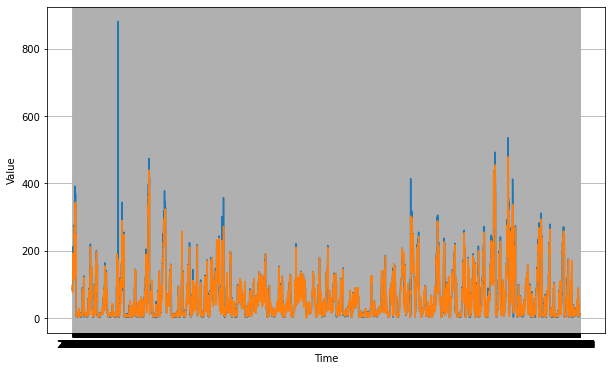

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_validate, x_validate)
plot_series(time_validate, rnn_forecast)

In [20]:
print("MAE = " + str(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()))
print("MAPE = " + str(tf.keras.metrics.mean_absolute_percentage_error(x_valid, rnn_forecast).numpy()))

MAE = 9.021401
MAPE = 27.415276


In [21]:
print(rnn_forecast)

[92.31908  96.72063  85.47972  ... 12.525868  9.912601  9.880913]


In [24]:
#Store forecast values to dataframe
data = {"PM25": x_validate, "PM25-Forecast": rnn_forecast}
df_forecast = pd.DataFrame(data)

In [25]:
df_forecast

,PM25,PM25-Forecast
0,98.0,92.319077
1,90.0,96.720627
2,82.0,85.479721
3,89.0,76.773331
4,84.0,88.081696
...,...,...
9881,11.0,8.637076
9882,13.0,10.448045
9883,9.0,12.525868
9884,10.0,9.912601


In [35]:
!mkdir -p saved_model

In [36]:
model.save('saved_model/AQI_hourly')

INFO:tensorflow:Assets written to: saved_model/AQI_hourly/assets


INFO:tensorflow:Assets written to: saved_model/AQI_hourly/assets


In [41]:
aqi_model = tf.keras.models.load_model('saved_model/AQI_hourly')
# Check its architecture
aqi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 60)          29040     
                                                                 
 lstm_1 (LSTM)               (None, None, 60)          29040     
                                                                 
 dense (Dense)               (None, None, 30)          1830      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

In [42]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [43]:
print(rnn_forecast)

[92.31908  96.72063  85.47972  ... 12.525868  9.912601  9.880913]
